In [6]:
# Import dependencies
import csv
import os
from classification_report_generator import generate_classification_report

# Combining Wiktionary and OPUS data

In [7]:
def combine_tsv(tsv_file1, tsv_file2, output_file):
    """
    Function to combine two TSV files into a single TSV file.

    Param:
        tsv_file1 (str): Path to the first input TSV file.
        tsv_file2 (str): Path to the second input TSV file.
        output_file (str): Path to the output TSV file.

    Returns:
        None
    """
    combined_rows = []
    with open(tsv_file1, 'r', encoding='utf-8') as file1, open(tsv_file2, 'r', encoding='utf-8') as file2:
        reader1 = csv.DictReader(file1, delimiter='\t')
        reader2 = csv.DictReader(file2, delimiter='\t')
        combined_rows.extend(reader1)
        combined_rows.extend(reader2)

    fieldnames = ['synset', 'language', 'lemma', 'count', 'goodness labels']

    with open(output_file, 'w', encoding='utf-8', newline='') as outfile:
        writer = csv.DictWriter(outfile, fieldnames=fieldnames, delimiter='\t')
        writer.writeheader()
        writer.writerows(combined_rows)

tsv_file1 = './data/synset_output_wiktionary_with_labels.tsv'
tsv_file2 = './data/synset_output_opus_with_labels.tsv'
output_file = './data/combined_wiktionary_opus_file.tsv'

combine_tsv(tsv_file1, tsv_file2, output_file)
print("TSV files combined and saved as:", output_file)

TSV files combined and saved as: ./data/combined_wiktionary_opus_file.tsv


# Matching the combined dataset with the evaluation set to be run on the system with the best condition 

In [8]:
def merge_tsv(tsv_file1, tsv_file2, output_file):
    """
    Function to merge data from two TSV files based on a common 'synset' and 'lemma' fields,
    and create a new TSV file containing the merged data.

    Param:
        tsv_file1 (str): The path to the first input TSV file.
        tsv_file2 (str): The path to the second input TSV file.
        output_file (str): The path to the output TSV file to save the merged data.

    Returns:
        None
    """
    merged_rows = []

    with open(tsv_file1, 'r', encoding='utf-8') as file1, open(tsv_file2, 'r', encoding='utf-8') as file2:
        reader1 = csv.DictReader(file1, delimiter='\t')
        reader2 = csv.DictReader(file2, delimiter='\t')
        
        # Create a dictionary to store rows from tsv_file1 for quick lookup
        tsv1_rows = {row['synset']: row for row in reader1}

        for row2 in reader2:
            synset = row2['synset']
            if synset in tsv1_rows:
                row1 = tsv1_rows[synset]
                confidence = int(row1['count'])
                language = row1['language']
            else:
                confidence = 'None'
                language = 'None'

            merged_row = {
                'synset': synset,
                'lemma': row2['lemma'],
                'annotation': row2['annotation'],
                'goodness label': row2['goodness label'],
                'confidence': confidence,
                'language': language
            }
            merged_rows.append(merged_row)

    fieldnames = ['synset', 'lemma', 'annotation', 'goodness label', 'confidence', 'language']
    with open(output_file, 'w', encoding='utf-8', newline='') as outfile:
        writer = csv.DictWriter(outfile, fieldnames=fieldnames, delimiter='\t')
        writer.writeheader()
        writer.writerows(merged_rows)

tsv_file1 = './data/combined_wiktionary_opus_file.tsv'
tsv_file2 = './data/evaluation_set_with_labels.tsv'
output_file = './data/merged_file_opus_wiktionary_eval.tsv'

merge_tsv(tsv_file1, tsv_file2, output_file)
print("TSV files merged and saved as:", output_file)

TSV files merged and saved as: ./data/merged_file_opus_wiktionary_eval.tsv


# Run the best condition

In [9]:
def process_synsets(input_tsv_path, output_tsv_path, threshold):
    """
    Function to process a TSV file, assigning prediction labels based on given criteria.
    Param:
        input_tsv_path (str): Path to the input TSV file.
        output_tsv_path (str): Path to the output TSV file.
        threshold (str): Threshold value for prediction label assignment.
    Returns:
        None
    """
    with open(input_tsv_path, 'r', encoding='utf-8') as tsv_file:
        reader = csv.DictReader(tsv_file, delimiter='\t')
        rows = list(reader)

    with open(output_tsv_path, 'w', newline='', encoding='utf-8') as tsv_file:
        writer = csv.writer(tsv_file, delimiter='\t')
        writer.writerow(['synset', 'lemma', 'annotation', 'prediction label'])

        for row in rows:
            synset = row['synset']
            lemma = row['lemma']
            annotation = row['annotation']
            goodness_label = row['goodness label']
            confidence_score = row['confidence']
            language = row['language']
            
            label = assign_label(synset, confidence_score, language, goodness_label, threshold)

            writer.writerow([synset, lemma, annotation, label])

    print(f"Prediction labels saved to '{output_tsv_path}' successfully.")
    
## Condition 5
def assign_label(synset, confidence_score, language, goodness_label, threshold):
    """
    Function to assign a label to a synset based on given criteria.

    Param:
        synset (str): The synset to be labeled.
        confidence_score (float): The confidence score associated with the synset.
        language (str): The language of the synset.
        goodness_label (str): The goodness label associated with the synset.
        threshold (str): The threshold value used for comparison with confidence_score.

    Returns:
        str: The label assigned to the synset based on the predefined condition.
    """
    if goodness_label == 'O' and synset.endswith('-v') and confidence_score == threshold and language == 'English': #0.5199
        return 'DELETE'
    elif goodness_label == 'X' and synset.endswith('-v') and confidence_score == threshold and language == 'English':
        return 'DELETE'
    else:
        return 'KEEP'

input_tsv_path = './data/merged_file_opus_wiktionary_eval.tsv'
output_tsv_path = './predictions_results/wiktionary_opus_condition_five_eval.tsv'
threshold = '1'
process_synsets(input_tsv_path, output_tsv_path, threshold)

Prediction labels saved to './predictions_results/wiktionary_opus_condition_five_eval.tsv' successfully.


# Generating classification report for files stored in predictions_results folder

Generating classification report for file: wiktionary_opus_condition_five_eval.tsv
Confusion Matrix:
True Positive (TP): 327
True Negative (TN): 3718
False Positive (FP): 379
False Negative (FN): 500
Precision: 0.4631728045325779
Recall: 0.3954050785973398
F1-score: 0.426614481409002


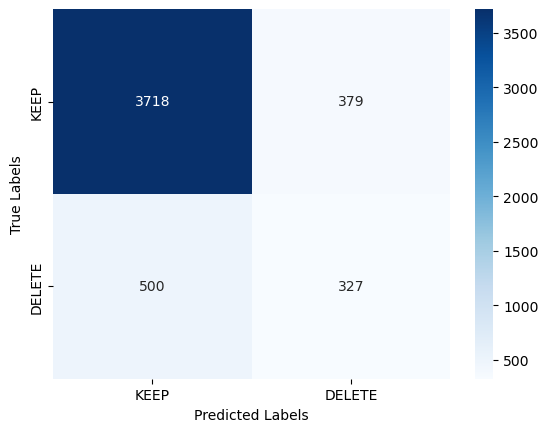

In [11]:
folder_path = 'predictions_results'

for filename in os.listdir(folder_path):
    if filename.endswith('five_eval.tsv'):
        file_path = os.path.join(folder_path, filename)
        print(f"Generating classification report for file: {filename}")
        generate_classification_report(file_path)
        print() 

# Match the combined dataset prediction results on evaluation set for data analysis

In [13]:
def count_senses(file_path):
    """
    Function to count and categorize senses from a TSV file.

    Param:
        file_path (str): Path to the input TSV file.

    Returns:
        None
    """
    with open(file_path, 'r', encoding='utf-8') as tsvfile:
        tsvreader = csv.reader(tsvfile, delimiter='\t')
        header = next(tsvreader) 

        # Initialize counters for KEEP and DELETE
        total_senses_k = 0
        senses_k = 0
        senses_english_k = 0
        none_language_count_k = 0
        senses_2_languages_k = 0
        senses_2_english_k = 0
        others_k = 0
        
        total_senses_d = 0
        senses_d = 0
        senses_english_d = 0
        none_language_count_d = 0
        senses_2_languages_d = 0
        senses_2_english_d = 0
        others_d = 0
        total_match = 4924

        for row in tsvreader:
            synset, lemma, annotation, goodness, confidence, language = row
            
            if annotation == 'KEEP':
                total_senses_k += 1
                if confidence == '1':
                    senses_k += 1
                if confidence == '1' and language == 'English':
                    senses_english_k += 1
                if confidence == 'None' and language == 'None':  
                    none_language_count_k += 1

                if confidence == '2':
                    senses_2_languages_k += 1

                if confidence == '2' and 'English' in language:
                    senses_2_english_k += 1

            elif annotation == 'DELETE':
                total_senses_d += 1

                if confidence == '1':
                    senses_d += 1

                if confidence == '1' and language == 'English':
                    senses_english_d += 1

                if confidence == 'None' and language == 'None':  
                    none_language_count_d += 1

                if confidence == '2':
                    senses_2_languages_d += 1

                if confidence == '2' and 'English' in language:
                    senses_2_english_d += 1

        # Calculate "Others" count outside the loops
#         others_k = total_senses_k - (senses_k + senses_english_k + none_language_count_k + senses_2_languages_k + senses_2_english_k)
#         others_d = total_senses_d - (senses_d + senses_english_d + none_language_count_d + senses_2_languages_d + senses_2_english_d)

    print("KEEP:")
    print(f"Total senses: {total_senses_k}")
    print(f"Suggested by 1 language: {senses_k}")
    print(f"Suggested by 1 language and that language is English: {senses_english_k}")
    print(f"Has None in language and count: {none_language_count_k}")
    print(f"Suggested by 2 languages: {senses_2_languages_k}")
    print(f"Suggested by 2 languages and one of the languages is English: {senses_2_english_k}")
    print(f"Others: {others_k}")
    

    print("\nDELETE:")
    print(f"Total senses: {total_senses_d}")
    print(f"Suggested by 1 language: {senses_d}")
    print(f"Suggested by 1 language and that language is English: {senses_english_d}")
    print(f"Has None in language and count: {none_language_count_d}")
    print(f"Suggested by 2 languages: {senses_2_languages_d}")
    print(f"Suggested by 2 languages and one of the languages is English: {senses_2_english_d}")
    print(f"Others: {others_d}")
    print(f"Total matches: {total_match - (none_language_count_k + none_language_count_d)}")

file_path = "./data/merged_file_wiktionary_eval.tsv"
count_senses(file_path)

print('=============')
file_path = "./data/merged_file_opus_eval.tsv"
count_senses(file_path)

KEEP:
Total senses: 4097
Suggested by 1 language: 2060
Suggested by 1 language and that language is English: 701
Has None in language and count: 1306
Suggested by 2 languages: 327
Suggested by 2 languages and one of the languages is English: 116
Others: 0

DELETE:
Total senses: 827
Suggested by 1 language: 634
Suggested by 1 language and that language is English: 235
Has None in language and count: 85
Suggested by 2 languages: 81
Suggested by 2 languages and one of the languages is English: 28
Others: 0
Total matches: 3533
KEEP:
Total senses: 4097
Suggested by 1 language: 3175
Suggested by 1 language and that language is English: 1922
Has None in language and count: 763
Suggested by 2 languages: 123
Suggested by 2 languages and one of the languages is English: 82
Others: 0

DELETE:
Total senses: 827
Suggested by 1 language: 771
Suggested by 1 language and that language is English: 487
Has None in language and count: 52
Suggested by 2 languages: 4
Suggested by 2 languages and one of the